In [65]:
# import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

# Import UUID to generate unique file names
import uuid

In [66]:
# Import Tensorflow Libraries - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [67]:
# Avoid OOM errosby setting GPU Memory Coonsumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimaental.set_memory_growth(gpu, True)

## Collecting Negative Dataset

In [68]:
# setup path


PDS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [69]:
# Make Directories


# os.makedirs(PDS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [70]:
# Move lfw images to the follwoing repository


# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

## Collecting positive and anchor dataset

In [71]:
# Establish a connection to webcam
# It is set to 4 so that this cell doesnt accidently run, set it to 0 to start capturing images from webcam
# q to quit, a to save anchor images, p to save positive images

cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()

    # Resizing the frame to 250x250
    frame = frame[120:120+250, 200:200+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        cv2.imwrite(os.path.join(ANC_PATH, f'{uuid.uuid1()}.jpg'), frame)

    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        cv2.imwrite(os.path.join(PDS_PATH, f'{uuid.uuid1()}.jpg'), frame)

    cv2.imshow('Image Collection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [158]:
# Getting image directory paths for anchor, negative and positive images

anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(PDS_PATH + '/*.jpg').take(300)

In [159]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\33d9d114-0d9f-11f1-81a8-c8a3e8774b86.jpg'


## Preprocessing

In [160]:
def preprocess(file_path):
    """
    Preprocesses an image file for face recognition model input.
    
    This function reads a JPEG image from the given file path, decodes it,
    resizes it to 100x100 pixels, and normalizes pixel values to the range [0, 1].
    
    Args:
        file_path (str): Path to the JPEG image file.
    
    Returns:
        tf.Tensor: Preprocessed image tensor with shape (100, 100, 3) and values in [0, 1].
    """
    # Read the image file as raw bytes
    byte_img = tf.io.read_file(file_path)
    
    # Decode the JPEG bytes into a tensor
    img = tf.io.decode_jpeg(byte_img)
    
    # Resize the image to 100x100 pixels using bilinear interpolation
    img = tf.image.resize(img, (100, 100))
    
    # Normalize pixel values from [0, 255] to [0, 1]
    img = img / 255.0
    
    return img

In [161]:
preprocess('data\\anchor\\33a95d01-0d9f-11f1-8a94-c8a3e8774b86.jpg')

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.9372549 , 0.9411765 , 0.92156863],
        [0.9372549 , 0.9411765 , 0.92156863],
        [0.9372549 , 0.9411765 , 0.92156863],
        ...,
        [0.9372549 , 0.9411765 , 0.91764706],
        [0.9372549 , 0.9411765 , 0.91764706],
        [0.9372549 , 0.9411765 , 0.91764706]],

       [[0.9372549 , 0.9411765 , 0.92156863],
        [0.9372549 , 0.9411765 , 0.92156863],
        [0.9372549 , 0.9411765 , 0.92156863],
        ...,
        [0.93333334, 0.94411767, 0.91862744],
        [0.93333334, 0.94411767, 0.91862744],
        [0.93333334, 0.94411767, 0.91862744]],

       [[0.9372549 , 0.9411765 , 0.92156863],
        [0.9372549 , 0.9411765 , 0.92156863],
        [0.9372549 , 0.9411765 , 0.92156863],
        ...,
        [0.93333334, 0.9411765 , 0.92156863],
        [0.93333334, 0.9411765 , 0.92156863],
        [0.93333334, 0.9411765 , 0.92156863]],

       ...,

       [[0.1254902 , 0.13333334, 0.0882353 ],
        [0.12

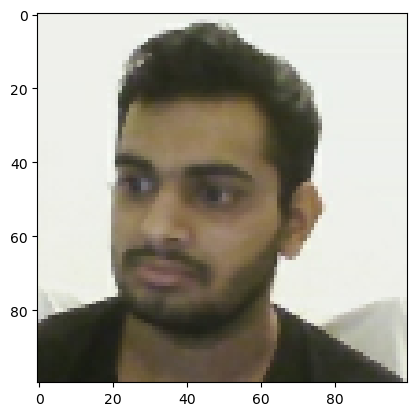

In [162]:
plt.imshow(preprocess('data\\anchor\\33a95d01-0d9f-11f1-8a94-c8a3e8774b86.jpg'))

In [163]:
preprocess('data\\anchor\\33a95d01-0d9f-11f1-8a94-c8a3e8774b86.jpg').numpy().max()

0.98357844

In [ ]:
dataset.map(preprocess)

## Create Labelled Dataset

In [164]:
# (anchor, positive) => 1, 1, 1, 1, 1
# (anchor, negative) => 0, 0, 0, 0, 0

In [165]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [166]:
samples = data.as_numpy_iterator()

In [167]:
example = samples.next()

In [168]:
example

(b'data\\anchor\\14716eb9-0d9f-11f1-8a48-c8a3e8774b86.jpg',
 b'data\\positive\\8008963a-0d9f-11f1-9017-c8a3e8774b86.jpg',
 1.0)

## Build Train and Test partition

In [169]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [170]:
res = preprocess_twin(*example)

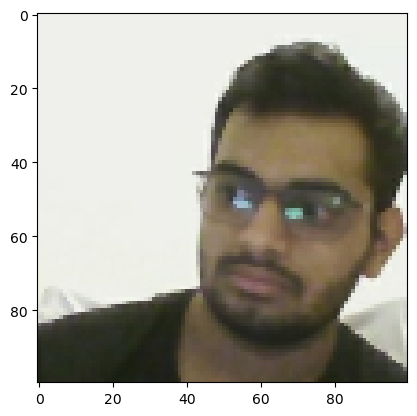

In [171]:
plt.imshow(res[0])

In [172]:
res[2]

1.0

In [173]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
# Create training partition (70%)
train_data = data.take(round(len(data) * 0.7))

# Apply batching and prefetching to training data
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# Create testing partition (remaining 30%)
test_data = data.skip(round(len(data) * 0.7))
test_data = test_data.take(round(len(data) * 0.3))

# Apply batching and prefetching to testing data
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)